In [1]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from subset_pca import *



from time import time

In [2]:
adult_test_df = pd.read_csv('datasets/benchmark/adult_clean_test.csv')
adult_train_df = pd.read_csv('datasets/benchmark/adult_clean_train.csv')
titanic_test_df = pd.read_csv('datasets/benchmark/titanic_clean_test.csv')
titanic_train_df = pd.read_csv('datasets/benchmark/titanic_clean_train.csv')
weather_test_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_test.csv')
weather_train_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_train.csv')
wine_test_df = pd.read_csv('datasets/benchmark/wine_test.csv')
wine_train_df = pd.read_csv('datasets/benchmark/wine_train.csv')

In [3]:
def extract_X_y(df, col_y):
    X = df.drop(col_y, axis=1)
    y = df[col_y]
    return X, y

In [4]:
adult_test_X, adult_test_y = extract_X_y(adult_test_df, 'income_>50k')
adult_train_X, adult_train_y = extract_X_y(adult_train_df, 'income_>50k')

titanic_test_X, titanic_test_y = extract_X_y(titanic_test_df, 'Survived')
titanic_train_X, titanic_train_y = extract_X_y(titanic_train_df, 'Survived')

weather_test_X, weather_test_y = extract_X_y(weather_test_df, 'RainTomorrow')
weather_train_X, weather_train_y = extract_X_y(weather_train_df, 'RainTomorrow')

wine_test_X, wine_test_y = extract_X_y(wine_test_df, 'quality')
wine_train_X, wine_train_y = extract_X_y(wine_train_df, 'quality')

In [5]:
def df_features_to_dicts(df):
    columns = df.columns
    dicts = []
   
    for index, row in df.iterrows():
        feature_dict = {}
        for col in columns:
            feature_dict[col] = row[col]
        dicts.append(feature_dict)
    return dicts

In [6]:
adult_test_dict_X = df_features_to_dicts(adult_test_X)
adult_train_dict_X = df_features_to_dicts(adult_train_X)

titanic_test_dict_X = df_features_to_dicts(titanic_test_X)
titanic_train_dict_X = df_features_to_dicts(titanic_train_X)

weather_test_dict_X = df_features_to_dicts(weather_test_X)
weather_train_dict_X = df_features_to_dicts(weather_train_X)

wine_test_dict_X = df_features_to_dicts(wine_test_X)
wine_train_dict_X = df_features_to_dicts(wine_train_X)

In [7]:
titanic_train_X.shape

(1047, 20)

In [8]:
titanic_train_y.shape

(1047,)

In [9]:
len(titanic_train_dict_X)

1047

In [10]:
def compute_score(model, test_X, test_y):
    pred = model.predict(test_X)
    acc = accuracy_score(pred, test_y)
    f1 = f1_score(pred, test_y)
    conf = confusion_matrix(pred, test_y)

    return acc, f1, conf

In [11]:
def fit_compute_score(model, train_X, train_y, test_X, test_y):
    t0 = time()
    model.fit(train_X, train_y)
    duration = time() - t0
    train_acc, train_f1, train_conf = compute_score(model, train_X, train_y)
    test_acc, test_f1, test_conf = compute_score(model, test_X, test_y)
    print("duration", duration)
    print("train accuracy", train_acc)
    print("train f1", train_f1)
    print("train tn, fp, fn, tp", train_conf.ravel()) 
    print("test accuracy", test_acc)
    print("test f1", test_f1)
    print("test tn, fp, fn, tp", test_conf.ravel())
    print()
    
    return train_acc, train_f1, train_conf, test_acc, test_f1, test_conf

In [18]:
def compare_feature_hashing(train_X, train_dict_X, train_y, test_X, test_dict_X, test_y):
    clf_ridge_default = RidgeClassifier()
    print('ridge_default')
    ridge_default_train_acc, ridge_default_train_f1, ridge_default_train_conf, \
        ridge_default_test_acc, ridge_default_test_f1, ridge_default_test_conf = \
        fit_compute_score(clf_ridge_default, train_X, train_y, test_X, test_y)

    n_estimators = 1000
    clf_randfor_default = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    print('randfor_default')
    randfor_default_train_acc, randfor_default_train_f1, randfor_default_train_conf, \
        randfor_default_test_acc, randfor_default_test_f1, randfor_default_test_conf = \
        fit_compute_score(clf_randfor_default, train_X, train_y, test_X, test_y)

    ridge_train_acc = []
    ridge_train_f1 = []
    ridge_train_conf = []
    ridge_test_acc = []
    ridge_test_f1 = []
    ridge_test_conf = []
    randfor_train_acc = []
    randfor_train_f1 = []
    randfor_train_conf = []
    randfor_test_acc = []
    randfor_test_f1 = []
    randfor_test_conf = []
    
    t = np.arange(0.4, 1, 0.1)
    
    for i in t:
        pca = SubsetPCA(cutoff=i)
        # hasher = FeatureHasher(n_features=n_features)
        train_X_small = pca.fit_transform(train_X)
        test_X_small = pca.transform(test_X)
        
        print("cutoff correlation", i, "n_features", train_X_small.shape[1])
        print()

        clf_ridge_small = RidgeClassifier()
        print('ridge_small')
        ridge_small_train_acc, ridge_small_train_f1, ridge_small_train_conf, \
            ridge_small_test_acc, ridge_small_test_f1, ridge_small_test_conf = \
            fit_compute_score(clf_ridge_small, train_X_small, train_y, test_X_small, test_y)
        ridge_train_acc.append(ridge_small_train_acc)
        ridge_train_f1.append(ridge_small_train_f1)
        ridge_train_conf.append(ridge_small_train_conf)
        ridge_test_acc.append(ridge_small_test_acc)
        ridge_test_f1.append(ridge_small_test_f1)
        ridge_test_conf.append(ridge_small_test_conf)

        clf_randfor_small = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
        print('randfor_small')
        randfor_small_train_acc, randfor_small_train_f1, randfor_small_train_conf, \
            randfor_small_test_acc, randfor_small_test_f1, randfor_small_test_conf = \
            fit_compute_score(clf_randfor_small, train_X_small, train_y, test_X_small, test_y)
        randfor_train_acc.append(randfor_small_train_acc)
        randfor_train_f1.append(randfor_small_train_f1)
        randfor_train_conf.append(randfor_small_train_conf)
        randfor_test_acc.append(randfor_small_test_acc)
        randfor_test_f1.append(randfor_small_test_f1)
        randfor_test_conf.append(randfor_small_test_conf)

    fig, ax = plt.subplots(2, 2, figsize=(15,10), tight_layout=True)
    
    ax[0,0].plot(t, ridge_default_train_acc*np.ones(len(t)), label='ridge_default')
    ax[0,0].plot(t, randfor_default_train_acc*np.ones(len(t)), label='randfor_default')
    ax[0,0].plot(t, ridge_train_acc, label='ridge_small')
    ax[0,0].plot(t, randfor_train_acc, label='randfor_small')
    ax[0,0].set(xlabel='cutoff correlation', ylabel='accuracy', title='train')
    ax[0,0].legend()

    ax[0,1].plot(t, ridge_default_test_acc*np.ones(len(t)), label='ridge_default')
    ax[0,1].plot(t, randfor_default_test_acc*np.ones(len(t)), label='randfor_default')
    ax[0,1].plot(t, ridge_test_acc, label='ridge_small')
    ax[0,1].plot(t, randfor_test_acc, label='randfor_small')
    ax[0,1].set(xlabel='cutoff correlation', ylabel='accuracy', title='test')
    ax[0,1].legend()
    
    ax[1,0].plot(t, ridge_default_train_f1*np.ones(len(t)), label='ridge_default')
    ax[1,0].plot(t, randfor_default_train_f1*np.ones(len(t)), label='randfor_default')
    ax[1,0].plot(t, ridge_train_f1, label='ridge_small')
    ax[1,0].plot(t, randfor_train_f1, label='randfor_small')
    ax[1,0].set(xlabel='cutoff correlation', ylabel='f1', title='train')
    ax[1,0].legend()
    
    ax[1,1].plot(t, ridge_default_test_f1*np.ones(len(t)), label='ridge_default')
    ax[1,1].plot(t, randfor_default_test_f1*np.ones(len(t)), label='randfor_default')
    ax[1,1].plot(t, ridge_test_f1, label='ridge_small')
    ax[1,1].plot(t, randfor_test_f1, label='randfor_small')
    ax[1,1].set(xlabel='cutoff correlation', ylabel='f1', title='test')
    ax[1,1].legend()

    plt.show()

ridge_default
duration 0.10396718978881836
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 11.131639003753662
train accuracy 0.9999488137588616
train f1 0.9998922529899795
train tn, fp, fn, tp [29791     0     2  9280]
test accuracy 0.8564847988535162
test f1 0.6794695930498399
test tn, fp, fn, tp [6881  921  481 1486]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.4 n_features 78

ridge_small
duration 0.09500360488891602
train accuracy 0.8229979781434751
train f1 0.5162283156127588
train tn, fp, fn, tp [28467  5590  1326  3690]
test accuracy 0.8159484082301157
test f1 0.509814612868048
test tn, fp, fn, tp [7036 1472  326  935]

randfor_small
duration 12.402175903320312
train accuracy 0.9999488137588616
train f1 0.9998922529899795
train tn, fp, fn, tp [29791     0     2  9280]
test accuracy 0.8435868563824342
test f1 0.6421545667447308
test tn, fp, fn, tp [6870 1036  492 1371]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.5 n_features 83

ridge_small
duration 0.10500407218933105
train accuracy 0.8229723850229058
train f1 0.5161245190626093
train tn, fp, fn, tp [28467  5591  1326  3689]
test accuracy 0.8158460436073293
test f1 0.5094082356149441
test tn, fp, fn, tp [7036 1473  326  934]

randfor_small
duration 12.851065397262573
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8434844917596479
test f1 0.6433403312339632
test tn, fp, fn, tp [6861 1028  501 1379]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.6 n_features 87

ridge_small
duration 0.11098194122314453
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_small
duration 12.391387939453125
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8567918927218753
test f1 0.6803746858578935
test tn, fp, fn, tp [6881  918  481 1489]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.7 n_features 88

ridge_small
duration 0.10799956321716309
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_small
duration 12.68946123123169
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8570989865902344
test f1 0.6812785388127854
test tn, fp, fn, tp [6881  915  481 1492]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.7999999999999999 n_features 89

ridge_small
duration 0.10699701309204102
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_small
duration 12.748595952987671
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8558706111167981
test f1 0.678391959798995
test tn, fp, fn, tp [6876  922  486 1485]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.8999999999999999 n_features 90

ridge_small
duration 0.11299991607666016
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_small
duration 12.634042263031006
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8559729757395844
test f1 0.6783999999999999
test tn, fp, fn, tp [6878  923  484 1484]



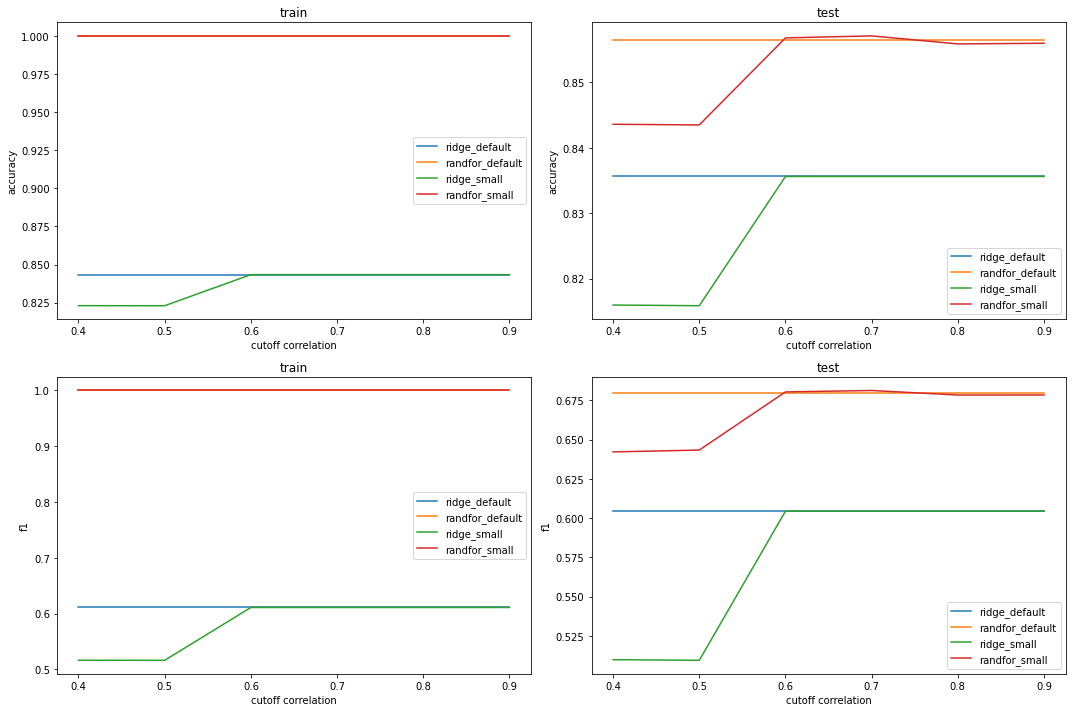

In [19]:
compare_feature_hashing(adult_train_X, adult_train_dict_X, adult_train_y, adult_test_X, adult_test_dict_X, adult_test_y)

ridge_default
duration 0.007020711898803711
train accuracy 0.8538681948424068
train f1 0.7994757536041939
train tn, fp, fn, tp [589  83  70 305]
test accuracy 0.8664122137404581
test f1 0.8223350253807108
test tn, fp, fn, tp [146  25  10  81]

randfor_default
duration 1.321091651916504
train accuracy 0.9808978032473734
train f1 0.9740932642487047
train tn, fp, fn, tp [651  12   8 376]
test accuracy 0.8282442748091603
test f1 0.7668393782383419
test tn, fp, fn, tp [143  32  13  74]

cutoff correlation 0.4 n_features 13

ridge_small
duration 0.00403141975402832
train accuracy 0.8548233046800382
train f1 0.8015665796344648
train tn, fp, fn, tp [588  81  71 307]
test accuracy 0.8664122137404581
test f1 0.8223350253807108
test tn, fp, fn, tp [146  25  10  81]

randfor_small
duration 1.3382484912872314
train accuracy 0.9808978032473734
train f1 0.9738219895287958
train tn, fp, fn, tp [655  16   4 372]
test accuracy 0.816793893129771
test f1 0.76
test tn, fp, fn, tp [138  30  18  76]

cutoff 

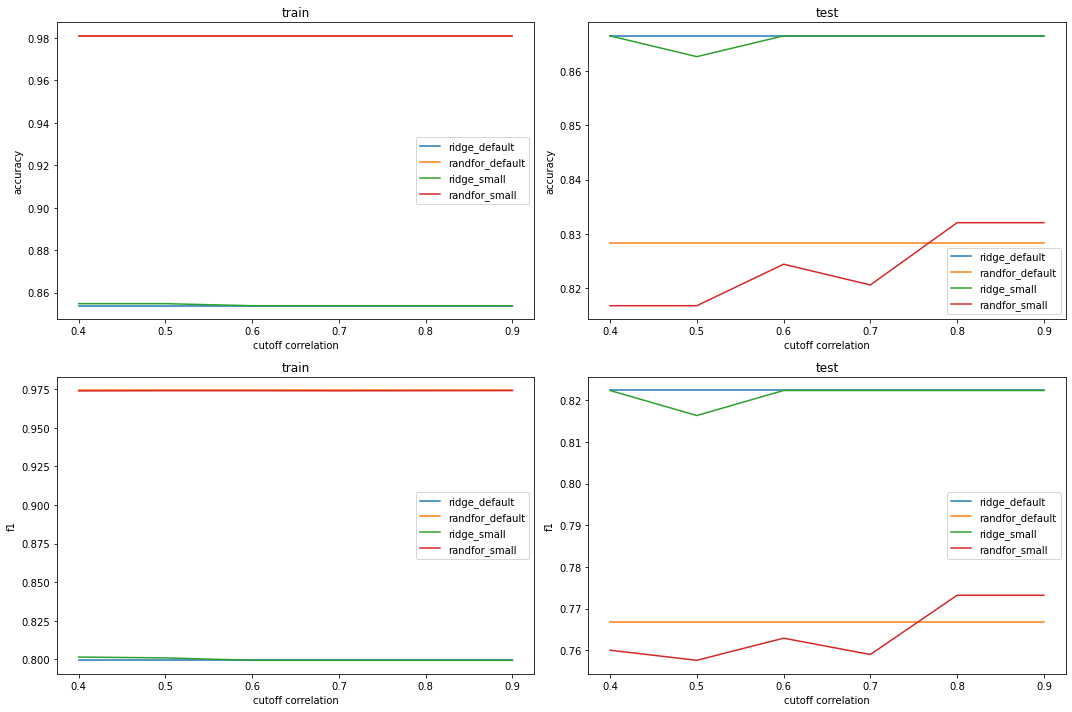

In [20]:
compare_feature_hashing(titanic_train_X, titanic_train_dict_X, titanic_train_y, titanic_test_X, titanic_test_dict_X, titanic_test_y)

ridge_default


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.07600116729736328
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_default


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 8.741108655929565
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


cutoff correlation 0.4 n_features 6

ridge_small
duration 0.0319981575012207
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 8.893462896347046
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


cutoff correlation 0.5 n_features 11

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.04300260543823242
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 9.057324409484863
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.6 n_features 16

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.07100296020507812
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 8.520252466201782
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.7 n_features 25

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.0689997673034668
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.890336036682129
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.7999999999999999 n_features 25

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.08600020408630371
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 7.973773717880249
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


cutoff correlation 0.8999999999999999 n_features 27

ridge_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 0.07799768447875977
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_small


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


duration 8.062837839126587
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]



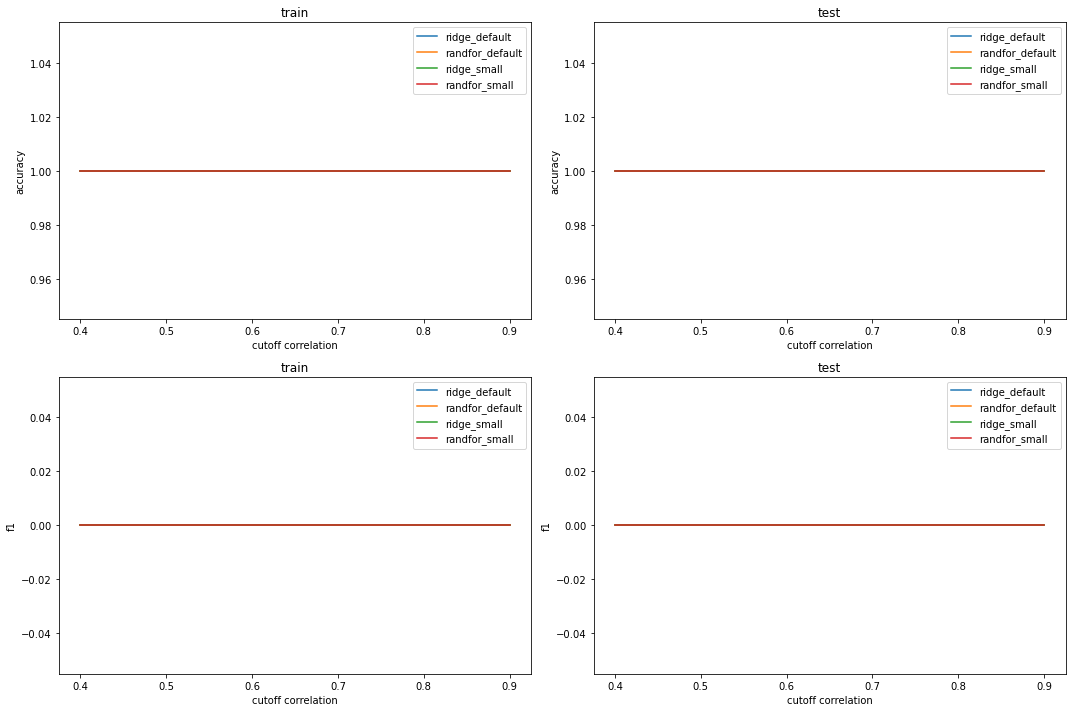

In [21]:
compare_feature_hashing(weather_train_X, weather_train_dict_X, weather_train_y, weather_test_X, weather_test_dict_X, weather_test_y)

ridge_default
duration 0.006000518798828125
train accuracy 0.7490226739640344
train f1 0.7602688573562361
train tn, fp, fn, tp [449 174 147 509]
test accuracy 0.740625
test f1 0.7446153846153846
test tn, fp, fn, tp [116  51  32 121]

randfor_default
duration 1.4134581089019775
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.81875
test f1 0.8242424242424243
test tn, fp, fn, tp [126  36  22 136]

cutoff correlation 0.4 n_features 5

ridge_small
duration 0.002997875213623047
train accuracy 0.6700547302580141
train f1 0.7097661623108665
train tn, fp, fn, tp [341 167 255 516]
test accuracy 0.66875
test f1 0.7135135135135136
test tn, fp, fn, tp [ 82  40  66 132]

randfor_small
duration 1.3102104663848877
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.8
test f1 0.8106508875739645
test tn, fp, fn, tp [119  35  29 137]

cutoff correlation 0.5 n_features 6

ridge_small
duration 0.0030324459075927734
train accuracy 0.7

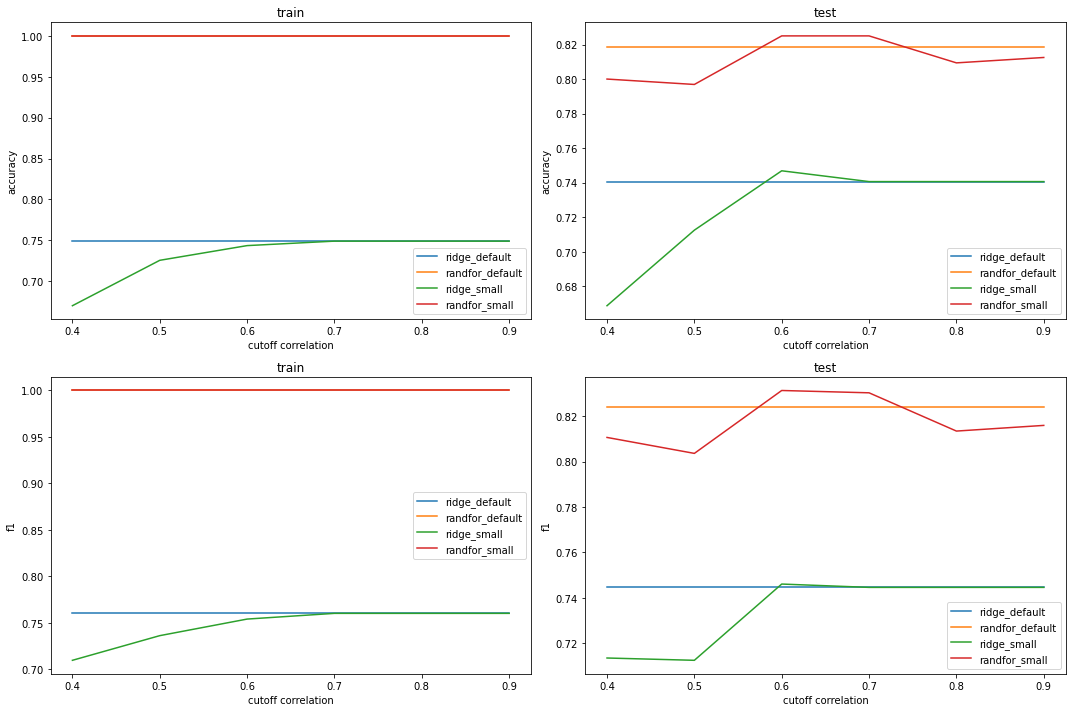

In [22]:
compare_feature_hashing(wine_train_X, wine_train_dict_X, wine_train_y, wine_test_X, wine_test_dict_X, wine_test_y)